# Find precipitation value for pulsed and upslope storms

In [1]:
import numpy as np
import netCDF4
import pandas as pd
import matplotlib.pyplot as plt


np.warnings.filterwarnings('ignore')



In [2]:
m = ['11', '12', '01', '02', '03']


### Minuelty data

In [78]:
#obs_double_fence_acc = []
#obs_double_fence_acc_mean = []
#obs_wind_dir_10m = []
#obs_wind_speed_10m = []
obs_f = dict()
obs_double_fence_acc_mean = dict()
obs_wind_dir_10m   = dict()
obs_wind_speed_10m = dict()
obs_dofe_acc   = dict()
obs_wind_dir   = dict()
obs_wind_speed = dict() 
obs_dofe_acc_rolling = dict()
obs_wind_dir_rolling = dict()
obs_wind_speed_rolling = dict()
obs_diff = dict()
westerly_idx = dict()
easterly_idx = dict()
westerly = dict()
easterly = dict()


for month in m:
    if month == '11':
        t = np.arange(7,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day

        obs_dirnc = '../../Data/Weathermast/Met_%s%s%s_Haukeliseter.nc' %(year,month,day)
        obs_f[int(year+month+day)] = netCDF4.Dataset(obs_dirnc, 'r')

     #   obs_double_fence_acc[int(year+month+day)] = (obs_f[int(year+month+day)].variables['double_fence_accum'][:])
        obs_double_fence_acc_mean[int(year+month+day)] = (np.nanmean(obs_f[int(year+month+day)].variables['double_fence_accum'][:], axis=1))
        obs_wind_dir_10m[int(year+month+day)]   = (obs_f[int(year+month+day)].variables['10m_wind_dir_mast1'][:])
        obs_wind_speed_10m[int(year+month+day)] = (obs_f[int(year+month+day)].variables['10m_wind_speed_mast1'][:])
        
        obs_f[int(year+month+day)].close
        
        ## Create a rolling mean to smoothen out the data
        # attach the last 9 minutes from the previous day to calculate the rolling mean every 10 minutes
        if month != '11' and day == '01':
            if month == '12':
                previous_day = '30'
            elif month == '01' or month == '02':
                previous_day = '31'
            elif month == '03':
                previous_day = '28'
            if month == '01':
                previous_month = '12'
                previous_year = str(int(year)-1)
            elif month == '12':
                previous_month = str(int(month)-1)
                previous_year = year
            else:
                previous_month = '0%s' %(int(month)-1)
                previous_year = year
            
        elif int(day)-1 < 10:
            previous_day = '0%s' %(int(day)-1)
            previous_month = month
            previous_year = year
        else:
            previous_day = '%s' %(int(day)-1)
            previous_month = month
            previous_year = year
        if year == '2016' and month == '11' and day == '07':
            continue
        else:
            pp = (np.concatenate((obs_double_fence_acc_mean[int(previous_year+previous_month+previous_day)][-9:],
                                  obs_double_fence_acc_mean[int(year+month+day)][:])))
            obs_dofe_acc[int(year+month+day)] = (pp)
            wd = (np.concatenate((obs_wind_dir_10m[int(previous_year+previous_month+previous_day)][-9:], 
                                  obs_wind_dir_10m[int(year+month+day)][:])))
            obs_wind_dir[int(year+month+day)] = (wd)
            ws = (np.concatenate((obs_wind_speed_10m[int(previous_year+previous_month+previous_day)][-9:], 
                                  obs_wind_speed_10m[int(year+month+day)][:])))
            obs_wind_speed[int(year+month+day)] = (ws)
        # Calculate the moving average. That is, take
        # the first ten values, average them, 
        # then drop the first and add the eleventh, etc.
        obs_dofe_acc[int(year+month+day)] = pd.DataFrame(np.array(obs_dofe_acc[int(year+month+day)])[:])
        obs_dofe_acc_rolling[int(year+month+day)] = obs_dofe_acc[int(year+month+day)].rolling(window=10,
                                                                                              min_periods= 7,
                                                                                              axis=0).mean()
        obs_dofe_acc_rolling[int(year+month+day)] = obs_dofe_acc_rolling[int(year+month+day)].values
        obs_dofe_acc_rolling[int(year+month+day)] = np.array(obs_dofe_acc_rolling[int(year+month+day)])[9:,:]

        obs_wind_dir[int(year+month+day)] = pd.DataFrame(np.array(obs_wind_dir[int(year+month+day)])[:])
        obs_wind_dir_rolling[int(year+month+day)] = obs_wind_dir[int(year+month+day)].rolling(window=10,
                                                                                              min_periods=7,
                                                                                              axis=0).mean()
        obs_wind_dir_rolling[int(year+month+day)] = obs_wind_dir_rolling[int(year+month+day)].values
        obs_wind_dir_rolling[int(year+month+day)] = np.array(obs_wind_dir_rolling[int(year+month+day)])[9:,:]

        obs_wind_speed[int(year+month+day)] = pd.DataFrame(np.array(obs_wind_speed[int(year+month+day)])[:])
        obs_wind_speed_rolling[int(year+month+day)] = obs_wind_speed[int(year+month+day)].rolling(window=10,
                                                                                                  min_periods=7,
                                                                                                  axis=0).mean()
        obs_wind_speed_rolling[int(year+month+day)] = obs_wind_speed_rolling[int(year+month+day)].values
        obs_wind_speed_rolling[int(year+month+day)] = np.array(obs_wind_speed_rolling[int(year+month+day)])[9:,:]
        
        
        # calculate the precipitation difference, since the minutelty data is accumulated from the beginning
        obs_diff[int(year+month+day)] = np.empty(shape=(obs_dofe_acc_rolling[int(year+month+day)].shape))#/60))
        obs_diff[int(year+month+day)][:] =  np.nan

        for i in np.arange(0,obs_dofe_acc_rolling[int(year+month+day)].shape[0]-1):#/60):
            obs_diff[int(year+month+day)][int(i),:] = obs_dofe_acc_rolling[int(year+month+day)][int(i)+1] - \
                                                      obs_dofe_acc_rolling[int(year+month+day)][int(i)]
                
#        print(year+month+day, np.nansum(obs_diff[int(year+month+day)]))

#    for day in np.arange(8,17):
        
 #       if day < 10:
  #          day = '0%s' %day
   #     else:
    #        day = '%s' %day

        # Find wind regimes and associated precip amount
        IDX = np.arange(obs_wind_dir_rolling[int(year+month+day)].shape[0])

        ## find all westerly regimes (202.5 - 22.5 deg) 
        westerly_idx[int(year+month+day)]  = IDX[np.logical_or(np.logical_and((obs_wind_dir_rolling[int(year+month+day)][:,0] >= 202.5), 
                                                                              (obs_wind_dir_rolling[int(year+month+day)][:,0] <= 360)),
                                                              (obs_wind_dir_rolling[int(year+month+day)][:,0] <22.5))]
        ## find all easterly regimes (22.5 - 202.5 deg)
        easterly_idx[int(year+month+day)]  = IDX[np.logical_and((obs_wind_dir_rolling[int(year+month+day)][:,0] >= 22.5),
                                                                (obs_wind_dir_rolling[int(year+month+day)][:,0] < 202.5))]

        ## find indices for all westerly regimes 
        sub_idx = []

        for i in range(0,westerly_idx[int(year+month+day)] .shape[0]-1):
        #for i in range(0,76):
            if westerly_idx[int(year+month+day)] [i]+1 == westerly_idx[int(year+month+day)] [i+1]:
                continue
            else:
                #print(i)
                sub_idx.append(i)
    
    #        print([int(year+month+day)], westerly_idx[int(year+month+day)], sub_idx)
        
        
        # find westerlies which are < 29 min and assign them to easterly wind regime
        if len(westerly_idx[int(year+month+day)]) == 0 and len(sub_idx) == 0:     # westerlies do not exist
            westerly[int(year+month+day)] = []
            easterly[int(year+month+day)] = easterly_idx[int(year+month+day)]
#            print('No westerly wind on %s' %(int(year+month+day)))
        elif len(westerly_idx[int(year+month+day)]) != 0 and len(sub_idx) == 0:   # westerlies exist only for one time period a day
            westerly[int(year+month+day)] = []
      #      easterly[int(year+month+day)] = []
            easterly[int(year+month+day)] = easterly_idx[int(year+month+day)]
            
            westerly_duration = westerly_idx[int(year+month+day)][-1] - westerly_idx[int(year+month+day)][0]
            if westerly_duration >= 28:
                westerly[int(year+month+day)] = np.concatenate((westerly[int(year+month+day)],
                                                                westerly_idx[int(year+month+day)][:]))
            elif westerly_duration < 28:
                easterly[int(year+month+day)] = np.concatenate((easterly[int(year+month+day)],
                                                                westerly_idx[int(year+month+day)][:]))
        else:
            westerly[int(year+month+day)] = []
         #   easterly[int(year+month+day)] = []
            easterly[int(year+month+day)] = easterly_idx[int(year+month+day)]

            for i in np.arange(0,np.array(sub_idx).shape[0]+1):                # westerlies and easterlies interchange daily
                if i == 0:
                    westerly_duration = (westerly_idx[int(year+month+day)] [ sub_idx[0]] - \
                                         westerly_idx[int(year+month+day)] [0])
                elif i == np.array(sub_idx).shape[0]:
                    westerly_duration = (westerly_idx[int(year+month+day)] [-1] - \
                                         westerly_idx[int(year+month+day)] [ sub_idx[np.array(sub_idx).shape[0]-1]+1])
                else:
                    westerly_duration = (westerly_idx[int(year+month+day)] [ sub_idx[i]] - \
                                         westerly_idx[int(year+month+day)] [ sub_idx[i-1]+1])
                if westerly_duration >= 28:
                    if i == 0:
                        westerly[int(year+month+day)] = np.concatenate((westerly[int(year+month+day)], 
                                                                        westerly_idx[int(year+month+day)] [ 0: sub_idx[0]+1]))
            #            print(westerly_duration, RR_westerly)
                    elif i == np.array(sub_idx).shape[0]:
                        westerly[int(year+month+day)] = np.concatenate((westerly[int(year+month+day)], 
                                                                        westerly_idx[int(year+month+day)] [ sub_idx[np.array(sub_idx).shape[0]-1]+1 : ]))
             #           print(westerly_duration, RR_westerly)
                    else:
                        westerly[int(year+month+day)] = np.concatenate((westerly[int(year+month+day)], 
                                                                        westerly_idx[int(year+month+day)] [ sub_idx[i-1]+1 : sub_idx[i]+1]))
              #          print(westerly_duration, RR_westerly)
                elif westerly_duration < 28:
                    if i == 0:
                        easterly[int(year+month+day)] = np.concatenate((easterly[int(year+month+day)], 
                                                                        westerly_idx[int(year+month+day)] [ 0: sub_idx[0]+1]))
                    elif i == np.array(sub_idx).shape[0]:
                        easterly[int(year+month+day)] = np.concatenate((easterly[int(year+month+day)],
                                                                        westerly_idx[int(year+month+day)] [ sub_idx[np.array(sub_idx).shape[0]-1]+1 : ]))
                    else:
                   # print(westerly_duration)
                        easterly[int(year+month+day)] = np.concatenate((easterly[int(year+month+day)],
                                                                        westerly_idx[int(year+month+day)] [ sub_idx[i-1]+1 : sub_idx[i]+1]))
        

        if len(westerly[int(year+month+day)]) == 0:    # only easterlies
            easterly[int(year+month+day)]  = easterly[int(year+month+day)].astype(int)

            print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][easterly_idx[int(year+month+day)],:]) + \
                           np.nansum(obs_diff[int(year+month+day)][westerly_idx[int(year+month+day)],:]),2 ),
                  'easterly [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][easterly[int(year+month+day)]]),2),
                  'westerly [mm/24h]:', 
                  np.round(len(westerly[int(year+month+day)]),2))
        elif len(easterly[int(year+month+day)]) == 0:  # only westerlies
            westerly[int(year+month+day)]  = westerly[int(year+month+day)].astype(int)

            print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][easterly_idx[int(year+month+day)],:]) + \
                           np.nansum(obs_diff[int(year+month+day)][westerly_idx[int(year+month+day)],:]),2 ),
                  'easterly [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][easterly[int(year+month+day)]]),2),
                  'westerly [mm/24h]:', 
                  np.round(len(westerly[int(year+month+day)]),2))
        else:    # both easterlies and westerlies
            easterly[int(year+month+day)]  = easterly[int(year+month+day)].astype(int)
            westerly[int(year+month+day)]  = westerly[int(year+month+day)].astype(int)
            
            print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][easterly_idx[int(year+month+day)],:]) + \
                           np.nansum(obs_diff[int(year+month+day)][westerly_idx[int(year+month+day)],:]),2 ),
                  'easterly [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][easterly[int(year+month+day)]]),2),
                  'westerly [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][westerly[int(year+month+day)]]),2))

[20161108] total precipitation [mm/24h]: -0.01 easterly [mm/24h]: -0.01 westerly [mm/24h]: 0
[20161109] total precipitation [mm/24h]: 0.31 easterly [mm/24h]: 0.31 westerly [mm/24h]: 0
[20161110] total precipitation [mm/24h]: 0.12 easterly [mm/24h]: 0.03 westerly [mm/24h]: 0.09
[20161111] total precipitation [mm/24h]: -0.03 easterly [mm/24h]: 0.14 westerly [mm/24h]: -0.17
[20161112] total precipitation [mm/24h]: 3.45 easterly [mm/24h]: 3.45 westerly [mm/24h]: 0
[20161113] total precipitation [mm/24h]: 1.47 easterly [mm/24h]: 1.11 westerly [mm/24h]: 0.36
[20161114] total precipitation [mm/24h]: 3.43 easterly [mm/24h]: 2.22 westerly [mm/24h]: 1.21
[20161115] total precipitation [mm/24h]: 4.44 easterly [mm/24h]: 2.38 westerly [mm/24h]: 2.06
[20161116] total precipitation [mm/24h]: 14.58 easterly [mm/24h]: 5.91 westerly [mm/24h]: 8.67
[20161117] total precipitation [mm/24h]: 9.0 easterly [mm/24h]: 1.58 westerly [mm/24h]: 7.42
[20161118] total precipitation [mm/24h]: 4.83 easterly [mm/24h]: 

[20170213] total precipitation [mm/24h]: -0.23 easterly [mm/24h]: -0.07 westerly [mm/24h]: -0.17
[20170214] total precipitation [mm/24h]: 0.05 easterly [mm/24h]: -0.15 westerly [mm/24h]: 0.2
[20170215] total precipitation [mm/24h]: -0.08 easterly [mm/24h]: 0.14 westerly [mm/24h]: -0.22
[20170216] total precipitation [mm/24h]: 0.73 easterly [mm/24h]: 0.23 westerly [mm/24h]: 0.5
[20170217] total precipitation [mm/24h]: -0.01 easterly [mm/24h]: -0.01 westerly [mm/24h]: -0.01
[20170218] total precipitation [mm/24h]: 1.55 easterly [mm/24h]: 0.02 westerly [mm/24h]: 1.54
[20170219] total precipitation [mm/24h]: 1.78 easterly [mm/24h]: 0.0 westerly [mm/24h]: 1440
[20170220] total precipitation [mm/24h]: 3.46 easterly [mm/24h]: 0.0 westerly [mm/24h]: 1440
[20170221] total precipitation [mm/24h]: 10.97 easterly [mm/24h]: 5.41 westerly [mm/24h]: 5.57
[20170222] total precipitation [mm/24h]: 29.3 easterly [mm/24h]: 6.28 westerly [mm/24h]: 23.02
[20170223] total precipitation [mm/24h]: 0.26 easterl

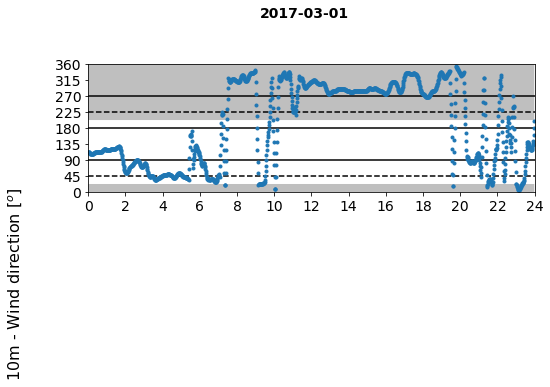

In [52]:
year = '2017'
month = '03'
day = '01'

fig = plt.figure(figsize=(8,8))

fig.text(.0, .5, '10m - Wind direction [$^{o}$]', ha='center', va='center', rotation='vertical', fontsize = 16)

ax1 = fig.add_subplot(311)
ax1.plot(obs_wind_dir_rolling[int(year+month+day)][:,:],'.')
ax1.hlines(270,0,obs_wind_dir_rolling[int(year+month+day)].shape[0])
ax1.hlines(180,0,obs_wind_dir_rolling[int(year+month+day)].shape[0])
ax1.hlines(90,0,obs_wind_dir_rolling[int(year+month+day)].shape[0])
ax1.hlines(45,0,obs_wind_dir_rolling[int(year+month+day)].shape[0], linestyles='dashed')
ax1.hlines(225,0,obs_wind_dir_rolling[int(year+month+day)].shape[0], linestyles='dashed')

ax1.fill_between(np.arange(obs_wind_dir_rolling[int(year+month+day)].shape[0]), 202.5, 360,  facecolor='gray', alpha=0.5)
ax1.fill_between(np.arange(obs_wind_dir_rolling[int(year+month+day)].shape[0]), 0, 22.5,  facecolor='gray', alpha=0.5)

ax1.set_xlim([0, obs_wind_dir_rolling[int(year+month+day)].shape[0]-1])
ax1.set_ylim([0, 360])
ax1.set_xticks(np.arange(0,obs_wind_dir_rolling[int(year+month+day)].shape[0]+120,120))    
ax1.set_xticklabels([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24 ])
ax1.set_yticks(np.arange(0,405,45))
fig.suptitle("%s-%s-%s" %(year,month,day), fontsize=14,fontweight='bold')
ax1.tick_params(labelsize=14)
plt.show()

In [ ]:
for seconds in westerly:
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    print('{:d}:{:02d}:{:02d}'.format(h, m, s)) # Python 3

### Eklima data

### MEPS data